In [1]:
import torch
import torch.nn as nn
import math
import os
import imageio
from matplotlib import pyplot as plt
from skimage.transform import rescale

In [2]:
lf = 3
dir_150 = f"../data/CAT_0{lf}/x1/x2"
dir_300 = f"../data/CAT_0{lf}/x1"
device = torch.device('cpu')
dtype = torch.float32

def read_image_folder(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image = imageio.imread(f'{directory}/{filename}')
            image = rescale(image=image, scale=1, multichannel=True, anti_aliasing=True)         
            images.append(image)
    return images

In [3]:
data_150 = read_image_folder(dir_150)
data_300 = read_image_folder(dir_300)

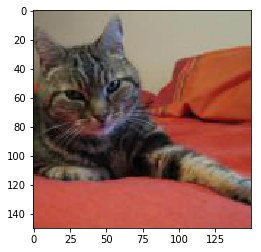

In [4]:
plt.imshow(data_150[0], interpolation='none')
plt.show()

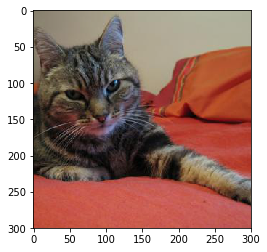

In [5]:
plt.imshow(data_300[0], interpolation='none')
plt.show()

In [6]:
x = torch.tensor(data_150, device = device, dtype = dtype)
data_150 = None
y = torch.tensor(data_300, device = device, dtype = dtype)
data_300 = None

In [7]:
# params
N = x.shape[0]

learning_rate = 0.001
batch_size = 1
epochs = 20

# Regularisierung
weight_decay = 0.001

In [8]:
# Neural Network
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 11, stride = 1, padding = 5),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size = 11, stride = 2, padding = 5, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size = 5, stride = 1, padding = 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = autoencoder()
#model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [ ]:
# Train
loss_hist = []
psnr_hist = []

for t in range(epochs):
    for batch in range(0, int(N/batch_size)):
            
        # Berechne den Batch
        batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
        # Berechne die Vorhersage (foward step)
        outputs = model.forward(batch_x)

        # Berechne den Fehler
        loss = criterion(outputs, batch_y)
        psnr = 10 * math.log10(1 / loss.item())
        
        # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    # Berechne den Fehler (Ausgabe des Fehlers alle x Iterationen)
    if t % 2 == 0:
        loss_hist.append(loss.item())
        psnr_hist.append(psnr)
        print(t, f"PSNR: {psnr}, MSE: {loss.item()}")

0 PSNR: 20.107972518404917, MSE: 0.009754449129104614
2 PSNR: 21.902250778550783, MSE: 0.006453196983784437
4 PSNR: 22.30715162901205, MSE: 0.005878747906535864
6 PSNR: 22.147789292735776, MSE: 0.006098472513258457


In [ ]:
plt.plot(loss_hist)

In [ ]:
plt.plot(psnr_hist)

In [ ]:
image = imageio.imread(f'../data/CAT_00/x1/00000001_020.jpg')
image_down = rescale(image=image, scale=0.5, multichannel=True, anti_aliasing=True).reshape(1, 150, 150, 3)

In [ ]:
image_up = model.forward(torch.tensor(image_down, dtype = dtype).transpose(1, 3))

In [ ]:
plt.imshow(image_up.transpose(1,3).detach().numpy().reshape(300, 300, 3), interpolation='none')
plt.show()